In [1]:
using Revise, BeamPropagation, Distributions, StatsBase, StaticArrays, PhysicalConstants.CODATA2018, Plots, BenchmarkTools

┌ Info: Precompiling BeamPropagation [3b7771b3-0fff-45f6-8d8e-6a934b658944]
└ @ Base loading.jl:1278
┌ Warning: Package BeamPropagation does not have LoopVectorization in its dependencies:
│ - If you have BeamPropagation checked out for development and have
│   added LoopVectorization as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with BeamPropagation
└ Loading LoopVectorization into BeamPropagation from project dependency, future warnings for BeamPropagation are suppressed.


In [2]:
const h = PlanckConstant.val
const ħ = h / 2π
const λ = @with_unit 626 "nm"
const k = 2π / λ
const m = @with_unit 57 "u"
const Δv = ħ * k / m
;

In [3]:
vz_μ = @with_unit 130 "m/s"
vz_σ = @with_unit 25 "m/s"
vxy_μ = @with_unit 0 "m/s"
vxy_σ = @with_unit 25 "m/s"
exit_radius = @with_unit 4 "mm"
;

In [4]:
const r = (
    Normal(0, exit_radius/2), 
    Normal(0, exit_radius/2), 
    Normal(0, 0)
)
const v = (
    Normal(vxy_μ, vxy_σ), 
    Normal(vxy_μ, vxy_σ), 
    Normal(vz_μ, vz_σ)
)
const a = (
    Normal(0, 0), 
    Normal(0, 0), 
    Normal(0, 0)
)
;

In [5]:
VBRs = Weights([
    0.9457,     # to 000
    0.0447,     # 100
    3.9e-3,     # 0200
    2.7e-3,     # 200
    9.9e-4,     # 0220
    7.5e-4,     # 0110
    3.8e-4,     # 0110, N=2
    3.9e-4,     # 1200
    1.5e-4,     # 300
    1.3e-4,     # 1220
    0.7e-4,     # 110 (only N=1, assuming roughly 2/3 to 1/3 rotational branching)
    0.4e-4,     # 110, N=2
    5.7e-5,     # 220
    4.3e-5      # other states
])

longitudinal = [
    true,   # to 000
    true,   # 100
    true,   # 0200
    true,   # 200
    true,   # 0220
    true,   # 0110
    true,   # 0110, N=2
    true,   # 1200
    true,   # 300
    false,   # 1220
    false,   # 110
    false,  # 110, N=2
    false,  # 220
    false   # other states
]

transverse = [
    false,  # to 000
    false,   # 100
    false,  # 0200
    false,  # 200
    false,  # 0220
    false,  # 0110
    false,  # 0110, N=2
    false,  # 1200
    false,   # 300
    true,   # 1220
    true,   # 110
    true,   # 110, N=2
    true,  # 220
    false   # other states
]

λs = 1e-9 .* [
    626,
    574,
    629,
    650,
    630,
    567,
    623,
    653,
    595,
    646,
    566,
    600,
    600,
    600
]

;

In [6]:
@inline function transverse_on(z)
    if 0.15 < z < 0.20
        return true
    elseif 0.45 < z < 0.50
        return true
    elseif 0.56 < z < 0.61
        return true
    end
    return false
end

@inline function random_unit3Dvector()
    θ = rand(Uniform(0, 2π))
    z = rand(Uniform(-1, 1))
    return @SVector [sqrt(1-z^2)*cos(θ), sqrt(1-z^2)*sin(θ), z]
end
;

In [7]:
const detect_rad  = @with_unit 0.5 "cm"
const detect_zloc = @with_unit 71 "cm"
const detect_zlen = @with_unit 0.5 "cm"
const dead_rad = @with_unit 1.0 "cm"
const dead_len = detect_zloc + detect_zlen
;

In [8]:
@inline function velocity_vector(r, v, Δv)
    
    # Assume the focus is ~0.5 m behind the cell
    focus_offset = 0.50
    z = r[3] + focus_offset
    
    squared_length = r[1]^2 + r[2]^2 + z^2
    
    x_comp = r[1] #r[1] / squared_length
    y_comp = r[2] #r[2] / squared_length
    z_comp = z #r[3] / squared_length
    
    return @SVector [v[1] - Δv * x_comp, v[2] - Δv * y_comp, v[3] - Δv * z_comp]
end

velocity_vector (generic function with 1 method)

In [9]:
@inline function simple_prop(r, v)
    dist_detect = detect_zloc - r[3]
    x_final = r[1] + v[1] * dist_detect / v[3]
    y_final = r[2] + v[2] * dist_detect / v[3]
    return sqrt(x_final^2 + y_final^2)
end
@inline discard(r, v) = (simple_prop(r, v) > dead_rad) || (r[3] > dead_len)
@inline is_detectable(r) = sqrt(r[1]^2 + r[2]^2) < detect_rad && (detect_zloc + detect_zlen > r[3] > detect_zloc)

@inline function save(i, r, v, a, state, s)
    s.vzs[i] = v[3]
    s.detectable[i] = simple_prop(r, v) < detect_rad
    return nothing
end

@inline function f(i, r, v, a, state, dt, p, s)
    if is_detectable(r) && ~s.detectable[i]
        s.detectable[i] = true
    end
    if p.longitudinal[state] || (p.transverse[state] && transverse_on(r[3])) 
        state′ = sample(1:14, p.VBRs)
        v′ = velocity_vector(r, v, Δv)
        v′ += Δv .* random_unit3Dvector()
        s.photons[i] += 1
    else
        state′ = state
        v′ = v
    end
    s.vzs[i] = v′[3]
    s.states[i] = state′
    return (state′, v′, a)
end
;

In [10]:
n = Int64(30e6)
scattering_rate = @with_unit 1.6 "MHz"
save_every      = 100
delete_every    = 15
dt              = 1 / scattering_rate
max_steps       = Int64(3.5e4)
;

In [16]:
vzs           = zeros(Float64, n)
photons       = zeros(Int64, n)
detectable    = zeros(Bool, n)
states        = ones(Int64, n)

p  = @params (VBRs, transverse, longitudinal, scattering_rate)
s = @params (vzs, photons, detectable, states)
s0 = deepcopy(s)
sf = deepcopy(s0)

@time s0, sf = propagate!(n, dt, r, v, a, f, save, discard, delete_every, max_steps, p, s0, sf)
bright = [longitudinal[final_state] for final_state in sf.states]
;

  3.164651 seconds (5.45 k allocations: 7.293 GiB, 6.92% gc time)


In [17]:
sum(sf.vzs[sf.detectable .& bright] .< 10)

28

In [18]:
sum(sf.vzs[sf.detectable .& bright] .< 20)

86

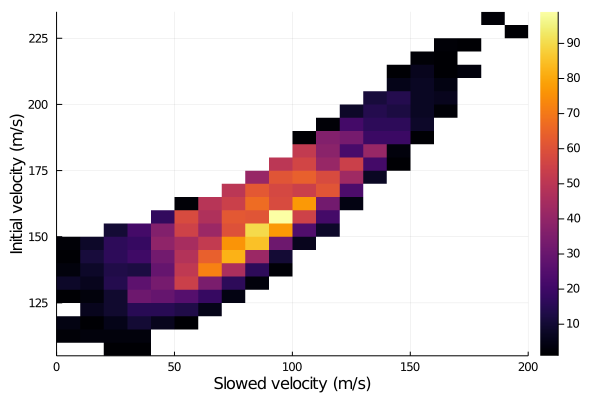

In [15]:
v_class = 0 .< sf.vzs .< 200
histogram2d(sf.vzs[sf.detectable .& bright .& v_class], s0.vzs[sf.detectable .& bright .& v_class], bins=30)
ylabel!("Initial velocity (m/s)")
xlabel!("Slowed velocity (m/s)")

In [851]:
# 70 cm
n = Int64(60e6)
Rs = [1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6] * 1e6
for R in Rs
    scattering_rate = R
    save_every      = 100
    delete_every    = 15
    dt              = 1 / scattering_rate
    max_steps       = Int64(3.5e4)
    
    vzs           = zeros(Float64, n)
    photons       = zeros(Int64, n)
    detectable    = zeros(Bool, n)
    states        = ones(Int64, n)

    p  = @params (VBRs, transverse, longitudinal, scattering_rate)
    s = @params (vzs, photons, detectable, states)
    s0 = deepcopy(s)
    sf = deepcopy(s0)

    @time s0, sf = propagate!(n, dt, r, v, a, f, save, discard, delete_every, max_steps, p, s0, sf)
    bright = [longitudinal[final_state] | transverse[final_state] for final_state in sf.states]
    
    print(sum(sf.vzs[sf.detectable .& bright] .< 20))
end

  6.893140 seconds (5.49 k allocations: 14.585 GiB, 13.89% gc time)
339  6.812096 seconds (5.60 k allocations: 14.585 GiB, 7.96% gc time)
424  6.988646 seconds (5.59 k allocations: 14.585 GiB, 7.38% gc time)
500  7.246986 seconds (5.59 k allocations: 14.585 GiB, 6.96% gc time)
557  7.523552 seconds (5.59 k allocations: 14.585 GiB, 6.79% gc time)
569  7.514658 seconds (5.59 k allocations: 14.585 GiB, 5.82% gc time)
534  7.877009 seconds (5.60 k allocations: 14.585 GiB, 6.89% gc time)
506  8.089323 seconds (5.60 k allocations: 14.585 GiB, 5.80% gc time)
449  8.547525 seconds (5.61 k allocations: 14.585 GiB, 5.31% gc time)
364

In [856]:
# 60 cm
n = Int64(60e6)
Rs = [1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6] * 1e6
for R in Rs
    scattering_rate = R
    save_every      = 100
    delete_every    = 15
    dt              = 1 / scattering_rate
    max_steps       = Int64(3.5e4)
    
    vzs           = zeros(Float64, n)
    photons       = zeros(Int64, n)
    detectable    = zeros(Bool, n)
    states        = ones(Int64, n)

    p  = @params (VBRs, transverse, longitudinal, scattering_rate)
    s = @params (vzs, photons, detectable, states)
    s0 = deepcopy(s)
    sf = deepcopy(s0)

    @time s0, sf = propagate!(n, dt, r, v, a, f, save, discard, delete_every, max_steps, p, s0, sf)
    bright = [longitudinal[final_state] | transverse[final_state] for final_state in sf.states]
    
    print(sum(sf.vzs[sf.detectable .& bright] .< 20))
end

  9.652985 seconds (1.26 M allocations: 14.648 GiB, 14.47% gc time)
229  9.392897 seconds (5.64 k allocations: 14.585 GiB, 6.36% gc time)
299  9.425380 seconds (5.64 k allocations: 14.585 GiB, 5.44% gc time)
448 10.759540 seconds (5.64 k allocations: 14.585 GiB, 6.38% gc time)
552 10.537902 seconds (5.63 k allocations: 14.585 GiB, 4.18% gc time)
683 10.983116 seconds (5.63 k allocations: 14.585 GiB, 5.52% gc time)
704 11.250141 seconds (5.63 k allocations: 14.585 GiB, 4.52% gc time)
801 12.237687 seconds (5.67 k allocations: 14.585 GiB, 4.04% gc time)
761 11.970899 seconds (5.65 k allocations: 14.585 GiB, 4.39% gc time)
818

In [861]:
# 50 cm
n = Int64(60e6)
Rs = [1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6] * 1e6
for R in Rs
    scattering_rate = R
    save_every      = 100
    delete_every    = 15
    dt              = 1 / scattering_rate
    max_steps       = Int64(3.5e4)
    
    vzs           = zeros(Float64, n)
    photons       = zeros(Int64, n)
    detectable    = zeros(Bool, n)
    states        = ones(Int64, n)

    p  = @params (VBRs, transverse, longitudinal, scattering_rate)
    s = @params (vzs, photons, detectable, states)
    s0 = deepcopy(s)
    sf = deepcopy(s0)

    @time s0, sf = propagate!(n, dt, r, v, a, f, save, discard, delete_every, max_steps, p, s0, sf)
    bright = [longitudinal[final_state] | transverse[final_state] for final_state in sf.states]
    
    print(sum(sf.vzs[sf.detectable .& bright] .< 20))
end

 12.741466 seconds (655.60 k allocations: 14.618 GiB, 10.21% gc time)
120 12.483829 seconds (5.71 k allocations: 14.585 GiB, 3.33% gc time)
184 14.773799 seconds (5.73 k allocations: 14.585 GiB, 3.47% gc time)
294 15.368566 seconds (5.68 k allocations: 14.585 GiB, 3.52% gc time)
388 15.893620 seconds (5.69 k allocations: 14.585 GiB, 2.56% gc time)
450 16.548944 seconds (5.67 k allocations: 14.585 GiB, 2.91% gc time)
557 17.404103 seconds (5.72 k allocations: 14.585 GiB, 2.86% gc time)
646 17.338199 seconds (5.69 k allocations: 14.585 GiB, 2.72% gc time)
758 18.449583 seconds (5.73 k allocations: 14.585 GiB, 3.13% gc time)
851

In [866]:
# 40 cm
n = Int64(60e6)
Rs = [1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6] * 1e6
for R in Rs
    scattering_rate = R
    save_every      = 100
    delete_every    = 15
    dt              = 1 / scattering_rate
    max_steps       = Int64(3.5e4)
    
    vzs           = zeros(Float64, n)
    photons       = zeros(Int64, n)
    detectable    = zeros(Bool, n)
    states        = ones(Int64, n)

    p  = @params (VBRs, transverse, longitudinal, scattering_rate)
    s = @params (vzs, photons, detectable, states)
    s0 = deepcopy(s)
    sf = deepcopy(s0)

    @time s0, sf = propagate!(n, dt, r, v, a, f, save, discard, delete_every, max_steps, p, s0, sf)
    bright = [longitudinal[final_state] | transverse[final_state] for final_state in sf.states]
    
    print(sum(sf.vzs[sf.detectable .& bright] .< 10))
end

 23.358660 seconds (651.09 k allocations: 14.617 GiB, 4.48% gc time)
50 26.180499 seconds (5.61 k allocations: 14.585 GiB, 2.16% gc time)
82 28.995871 seconds (5.60 k allocations: 14.585 GiB, 1.85% gc time)
107 30.752710 seconds (5.60 k allocations: 14.585 GiB, 1.63% gc time)
162 32.811115 seconds (5.62 k allocations: 14.585 GiB, 1.44% gc time)
191 35.541394 seconds (5.62 k allocations: 14.585 GiB, 1.06% gc time)
243 39.773232 seconds (5.66 k allocations: 14.585 GiB, 1.22% gc time)
263 40.742366 seconds (5.66 k allocations: 14.585 GiB, 1.07% gc time)
262 41.746713 seconds (5.65 k allocations: 14.585 GiB, 1.23% gc time)
265

In [867]:
# 40 cm
n = Int64(60e6)
Rs = [1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6] * 1e6
for R in Rs
    scattering_rate = R
    save_every      = 100
    delete_every    = 15
    dt              = 1 / scattering_rate
    max_steps       = Int64(3.5e4)
    
    vzs           = zeros(Float64, n)
    photons       = zeros(Int64, n)
    detectable    = zeros(Bool, n)
    states        = ones(Int64, n)

    p  = @params (VBRs, transverse, longitudinal, scattering_rate)
    s = @params (vzs, photons, detectable, states)
    s0 = deepcopy(s)
    sf = deepcopy(s0)

    @time s0, sf = propagate!(n, dt, r, v, a, f, save, discard, delete_every, max_steps, p, s0, sf)
    bright = [longitudinal[final_state] | transverse[final_state] for final_state in sf.states]
    
    print(sum(sf.vzs[sf.detectable .& bright] .< 10))
end

 23.328370 seconds (5.49 k allocations: 14.585 GiB, 5.83% gc time)
11 25.472098 seconds (5.61 k allocations: 14.585 GiB, 2.65% gc time)
20

LoadError: InterruptException: